<a href="https://colab.research.google.com/github/Pavlos01232/Match_Outcome_Prediction/blob/main/Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


'''



Historic Bookies Estimate:
==========================

The historic bookies estimate for goals landed by team i against team j is

a_i b_j

where

a_i = A_i C^{-1/2}
b_j = B_j C^{-1/2}

A_i = goals landed per game by team i
B_j = goals conceded per game by team j
C   = average goals per game of all teams


The historic 1980's max likelihood models
=========================================

Starting with Maher, the 1980's max likelihood model starts with this guess and
perfects it by max likelihood, when team i lands k goals agaist team j
loss was minus the log of the predicted probability by Poisson

- log ( e^{-a_ib_j}(a_ib_j)^k /k!)


A gitgub user said chi squared shows HST,AST,HR,AR have a significant effect

HST = home shots on target
AST = away shots on target
HR  = home red cards
AR  = away red cards
HS  = home shots
AS  = away shots
HC  = home quarter kicks
AC  = away corner kicks
HF  = home fouls
AF  = away fouls


New Cross-entropy AI model with a neural layer
==========================================

Since gradient descent generalizes max likelihood we can replace a_ib_j by

a_i b_j  +  (c_0 sigma ( c_3 HST + c_4 HR +c_5 HS + c_6 HC _c_7 HF)
             + ...
             +c_2 sigma(c_13 HST + c_14 HR + c_15 HS + c_16 HCC + c_17 HF) )b_j

when i is the home team and

a_i b_j  +  c_0 sigma ( c_1 AST + c_2 AR  ..... +AF  ) b_j

when i is the away team, with sigma being the sigmoid function


   sigma(x)=softmax(0,x) = e^x/(e^0+e^x) = 1/(1+e^{-x})



This puts a *neural layer* behind the standard max likelihood model from the 1980s

The weights are now the a_i,  b_i,   and c_i

Since the c_i are shared by all teams the training rate for the c_i should be lower

As in the model which this generalizes, the training is cross entropy versus the Poisson distribution.





A comment about the way the databases are stored, variables like HST and AST refer to 'home'
and 'away' team but we do not make a distinction between home versus away.

This means that each row of a data table is interpreted as if it were two rows,
one giving information about team i against team j, the other giving information
about team j against team i.

For instance to calculate the average goals scored by any team over all games
each row gives goals scored by a home team and goals scored by an away team
and we have to add 2 to total games.

That is when we say total games it really means the sum over all teams
of the number of games that team played in, which is twice the number
of games.

That explains the line  totalgames=totalgames+2 each time a row is read in.

There is no need to change this architecture to include things causing a home
team advantage. This starts with a constant taking the value 1 in the first line

loss -=  ...

and taking the value 0 in the second line

loss -= ...





'''


import torch as t
import torch.nn as n
import pandas as pd
import os
import math


def sigma(x):
  return t.exp(x)/(t.exp(t.tensor(1.0))+t.exp(x))-t.tensor(0.5)



t.set_printoptions(precision=10)
#print("beep boop")
#print("Aston Villa loses")
print("=============================================================")

#GITHUB LOCATION:
#https://github.com/Pavlos01232/Match_Outcome_Prediction
#
#
#
#
#
#
#




#pd.read_csv('https://raw.githubusercontent.com/Pavlos01232/Match_Outcome_Prediction/main/TRAINING%20DATA/PL0304.csv?raw=true')


#"DEEP learning" just means "hidden" layers


#df.to_csv(r'C:\Users\Pavlos\Desktop\export_dataframe.csv', sep='\t', encoding='utf-8')
#print (df[2])
#file_list = os.listdir('https://raw.githubusercontent.com/Pavlos01232/Match_Outcome_Prediction/main/TRAINING%20DATA/')
#df = pd.read_csv('https://raw.githubusercontent.com/Pavlos01232/Match_Outcome_Prediction/main/TRAINING%20DATA/PL0405.csv?raw=true',sep='\t', lineterminator='\r')
#print(df)

#read function

first = "https://raw.githubusercontent.com/Pavlos01232/Match_Outcome_Prediction/main/TRAINING%20DATA/PL"
last = ".csv?raw=true"




'''
Starting with an array of data frames,
and an array of column names, make a
single array with the chosen columns
'''




def combine(dataFrames,columnNames):
 t=[]
 for i in range(0,len(dataFrames)):
    theseColumns=dataFrames[i].columns.values[0].split(",")
    for j in range(0 ,len(dataFrames[i])):
      row=dataFrames[i].values[j][0].split(",")
      newEntry=[]
      for k in range(0, len(columnNames)):
         for m in range(0, len(theseColumns)):
             if(columnNames[k]==theseColumns[m] and m<=len(row)):
                newEntry.append(row[m])
      t.append(newEntry)
 return t




'''
can read years 3 to 23, 13*********************, there's something wrong with 14
since the first two files in the training data are formatted incorrectly
converts csv to dataframe
'''

df=[]

for i in range(3, 4):
  result = first + str('{:02.0f}'.format(i)) + str('{:02.0f}'.format(i+1)) + last
  x = pd.read_csv(result, sep='\t', encoding = 'unicode_escape', lineterminator='\r')
  df.append(x)




'''
Get an array with each (home) team listed once
from an array of data frames with column "HomeTeam"
'''





def getTeams(df):
 teams=[]
 homeTeams=combine(df,["HomeTeam"])
 for i in range(len(homeTeams)):
  if(len(homeTeams[i])>0):
   found=False
   for j in range(len(teams)):
    if homeTeams[i][0] == teams[j]:
      found=True
      break
   if found:
    continue
   teams.append(homeTeams[i][0])
 return teams


'''
Get the list of teams from the array of data frames called df
and print it to the console
'''


teams=getTeams(df)
print("\nteams:")
print(teams)





'''
Create an array called Data with just the team names and scores
from the data framees in the array of frames df, and print it

The list ["HomeTeam","AwayTeam","FTHG","FTAG","HST","AST","HR","AR"] can be
made longer if other columnts may be useful to use
'''



Data=combine(df, ["HomeTeam","AwayTeam","FTHG","FTAG","HST","AST","HR","AR", "HS","AS","HC","AC","HF","AF"])
#print("\n\ndata: (team names respective goals scored, respective shots on target, respective red cards, respective shots, respective corner-kicks, respective fouls)")
#print(Data)




'''
Get the numerical index of a team name x in the array teams
otherwise just return x
'''

def getIndex(x,teams):
  for i in range(len(teams)):
   if(teams[i]==x):
    return i
  return x


#print("\n\nIndex assigned to Everton:")
#print(getIndex("Everton",teams))


'''
Replace any occurrence of names from the array teams
which occur anywhere in A by their actual  numbers
'''

def teamsToNumbers(A,teams):
  B=[]
  for i in range(len(A)):
    B.append([])
    for j in range(len(A[i])):
      B[i].append(getIndex(A[i][j],teams))
  return B


'''
Create Data2 which is a copy of Data but with team names
replaced by their index
'''

#print("\n\ndata2, using the team's index number instead of name")
Data2=teamsToNumbers(Data,teams)
print(len(Data2))


'''
remove game 12 from Data2
Caution: these indices must be high enough not to disrupt the indices of team names
'''

excluded=[137, 141, 144, 150, 153, 163, 191, 191, 201]
if(len(excluded)>0):
  print("excluded: "+str(excluded))
  print("\nCAUTION: check that the teams list was not disrupted by exclusions:\n"+str(teams))
validateGame=[]
for i in range(len(excluded)):
 validateGame.append(Data2.pop(i))

'''

Assume Data2 has team indices in column 0 and 1 and scores
in cols 2 and 3

A[i] is array of average goals landed per game by tean i
B[i] is array of average goals conceded per game by team i
C is total games played by all teams (twide the number of games)
games[i]=total games played by team i
a[i]*b[j]=first approx of expected goals landed by i when playing
    against j
'''

A=[0]*len(teams)
B=[0]*len(teams)
games=[0]*len(teams)
a=[0]*len(teams)
b=[0]*len(teams)
C=0
totalGames=0

for i in range(len(Data2)):
  if(len(Data2[i])<2):
    continue
  games[Data2[i][0]]+=1
  games[Data2[i][1]]+=1
  A[Data2[i][0]]+=int(Data2[i][2])
  B[Data2[i][0]]+=int(Data2[i][3])
  A[Data2[i][1]]+=int(Data2[i][3])
  B[Data2[i][1]]+=int(Data2[i][2])
  C+=int(Data2[i][2])+int(Data2[i][3])
  totalGames+=2


'''
Initial estimates of a,b,c
'''

for i in range(len(A)):
  a[i]=A[i]/games[i]*(C/totalGames)**(-1/2)

for i in range(len(B)):
  b[i]=B[i]/games[i]*(C/totalGames)**(-1/2)

#c is another set of hidden weights for our weightrix. they are initally nonzero to avoid a stationary point.

c=[0.001,0.002,0.004,-0.001,-0.002,-0.004,0.0005,0.0001,0.01,0.002,0.005,0.007,0.009,0.003,0.007,0.009,0.002,-0.001]





'''
AI training function

The training is by gradient descent, the loss
function will be cross entropy loss function against Poisson
using loss.backward()

The hidden weights at the moment are the entries of a,b,c
the array c  is shared for all teams.
These enter into the calculation of mu (which we
call muHome or muAway during training) and are
hidden as they have no direct meaning.

Thus mu as a function of the entries of a,b,c is
learned by training, the weights are the entries
of the three arrays.



tau is the training rate for c which should be small
compared to eta

'''



def elementOf(i,A):
  for j in range(len(A)):
    if(A[j]==i):
      return True
  return False

def train(eta,tau):
  loss=t.tensor(0.0)



  atensor=t.tensor(a,requires_grad=True)
  btensor=t.tensor(b,requires_grad=True)
  ctensor=t.tensor(c,requires_grad=True)


  for i in range(len(Data2)):
    if(len(Data2[i])==0):
      continue
    homeTeam=int(Data2[i][0])
    awayTeam=int(Data2[i][1])
    homeGoals=int(Data2[i][2])
    awayGoals=int(Data2[i][3])
    HST=t.tensor(float(Data2[i][4]))
    AST=t.tensor(float(Data2[i][5]))
    HR=t.tensor(float(Data2[i][6]))
    AR=t.tensor(float(Data2[i][7]))
    HS=t.tensor(float(Data2[i][8]))
    AS=t.tensor(float(Data2[i][9]))
    HC=t.tensor(float(Data2[i][10]))
    AC=t.tensor(float(Data2[i][11]))
    HF=t.tensor(float(Data2[i][12]))
    AF=t.tensor(float(Data2[i][13]))




    '''
    The reason there are two lines of code for the loss is that
    each game can be thought of as  two 'rows' of data where we label
    the home team as team i  or team j.

    Thus teams are interpreted symmetrically and there is not yet any
    home team advantage but this can be put in
    without modifying the architecture as a constant which is 1 in the
    first line and 0 in the second
    '''


    muHome=atensor[homeTeam]*btensor[awayTeam]
    neural=ctensor[0]*sigma(ctensor[3]*HST+ctensor[4]*HR+ctensor[5]*HS+ctensor[6]*HC+ctensor[7]*HF)
    neural+=ctensor[1]*sigma(ctensor[8]*HST+ctensor[9]*HR+ctensor[10]*HS+ctensor[11]*HC+ctensor[12]*HF)
    neural+=ctensor[2]*sigma(ctensor[13]*HST+ctensor[14]*HR+ctensor[15]*HS+ctensor[16]*HC+ctensor[17]*HF)
    muHome=muHome+neural*btensor[awayTeam]

    muAway=atensor[awayTeam]*btensor[homeTeam]
    neural=ctensor[0]*sigma(ctensor[3]*AST+ctensor[4]*AR+ctensor[5]*AS+ctensor[6]*AC+ctensor[7]*AF)
    neural+=ctensor[1]*sigma(ctensor[8]*AST+ctensor[9]*AR+ctensor[10]*AS+ctensor[11]*AC+ctensor[12]*AF)
    neural+=ctensor[2]*sigma(ctensor[13]*AST+ctensor[14]*AR+ctensor[15]*AS+ctensor[16]*AC+ctensor[17]*AF)
    muAway=muAway+neural*btensor[homeTeam]


    loss-=t.log(t.exp(-muHome)*t.pow(muHome,homeGoals)/math.factorial(homeGoals))
    loss-=t.log(t.exp(-muAway)*t.pow(muAway,awayGoals)/math.factorial(awayGoals))

  loss.backward()
  for i in range(len(c)):
    c[i]=c[i]-tau*ctensor.grad[i]
  for i in range(len(a)):
    a[i]=a[i]-eta*atensor.grad[i]
  for i in range(len(b)):
    b[i]=b[i]-eta*btensor.grad[i]
  print("\n\nCross-entropy loss vs Poisson: "+str(loss))
  print("\n\nWeights:\n\na:  "+str(a))
  print("b:  "+str(b))
  print("c:  "+str(c))
  print("\n\n\n")
  print("Partial derivatives of loss w/r to hidden weights:")
  print("\natensor.grad: "+str(atensor.grad))
  print("btensor.grad: "+str(btensor.grad))
  print("ctensor.grad: "+str(ctensor.grad))
  print("\n\n\n")




'''
Use weights to construct predicted expected goals scored by i
against j and then find probability of k goals scored using
Poisson when given values of R S ST  C F are provided
'''

# non-tensor version of sigma for using in the field

def mathsigma(x):
  return math.exp(x)/(math.exp(0)+math.exp(x))-0.5

def goalProb(i,j,k,ST,R,S,C,F):
  mu=a[i]*b[j]
  mu+=c[0]*mathsigma(c[3]*ST+c[4]*R+c[5]*S+c[6]*C+c[7]*F)
  mu+=c[1]*mathsigma(c[8]*ST+c[9]*R+c[10]*S+c[11]*C+c[12]*F)
  mu+=c[2]*mathsigma(c[13]*ST+c[14]*R+c[15]*S+c[16]*C+c[17]*F)
  return math.exp(-mu)*mu**k/math.factorial(k)


def goalProb2(i,j,k):
  ST=preTrainST(i,j)
  R=preTrainR(i,j)
  S=preTrainS(i,j)
  C=preTrainC(i,j)
  F=preTrainF(i,j)
  #print("\nNaive prediction of ST, R, S, C, F: "+str(ST)+", "+str(R)+", "+str(S)+", "+str(C)+", "+str(F))
  return goalProb(i,j,k,ST,R,S,C,F)


'''
Pre-training estimates of ST, R, S, C, F
'''

def preTrain(i,j,u,v):
  X=0
  Y=0
  Z=0
  for s in range(len(Data2)):
    if(len(Data2[s])<2):
      continue
    if(Data2[s][0]==i):
      X+=int(Data2[s][u])
    if(Data2[s][0]==j):
      Y+=int(Data2[s][u])
    if(Data2[s][1]==i):
      X+=int(Data2[s][v])
    if(Data2[s][1]==j):
      Y+=int(Data2[s][v])
    Z+=int(Data2[s][u])+int(Data2[s][v])
  return (X/games[i])*(Y/games[j])/(Z/totalGames)

def preTrainST(i,j):
  return preTrain(i,j,4,5)

def preTrainR(i,j):
  return preTrain(i,j,6,7)

def preTrainS(i,j):
  return preTrain(i,j,8,9)

def preTrainC(i,j):
  return preTrain(i,j,10,11)

def preTrainF(i,j):
  return preTrain(i,j,12,13)


def expectedGoals(i,j):
  ST=preTrainST(i,j)
  R=preTrainR(i,j)
  S=preTrainS(i,j)
  C=preTrainC(i,j)
  F=preTrainF(i,j)
  mu=a[i]*b[j]
  mu+=c[0]*mathsigma(c[3]*ST+c[4]*R+c[5]*S+c[6]*C+c[7]*F)
  mu+=c[1]*mathsigma(c[8]*ST+c[9]*R+c[10]*S+c[11]*C+c[12]*F)
  mu+=c[2]*mathsigma(c[13]*ST+c[14]*R+c[15]*S+c[16]*C+c[17]*F)
  return mu

'''
Test training a bit
'''


'''
If training iterations is set to zero this is used
'''


import numpy

def readWeights():
 aLocal = numpy.fromfile('a.bin', dtype=numpy.float32)
 bLocal = numpy.fromfile('b.bin', dtype=numpy.float32)
 cLocal = numpy.fromfile('c.bin', dtype=numpy.float32)
 for i in range(len(a)):
  a[i]=aLocal[i]
 for i in range(len(b)):
  b[i]=bLocal[i]
 for i in range(len(c)):
  c[i]=cLocal[i]







print("\n\n Pre-training score table")
st="{:<17}".format("")
for i in range(len(teams)):
  st+="{:<17}".format(teams[i])
print (st)
for i in range(len(teams)):
  st="{:<17}".format(teams[i])
  for j in range(len(teams)):
    st+="{:<17}".format(       "%2.3f" % expectedGoals(i,j))
  print(st)
print("\n\n")






def  validate():
  MSE1=0.0
  MSE2=0.0
  loss1=0.0
  loss2=0.0
  for s in range(len(validateGame)):
    ii=validateGame[s][0]
    jj=validateGame[s][1]
    print("\nvalidating excluded game:"+teams[ii]+" vs " +teams[jj])
    print("pre-training prediction: "+str(expectedGoals(ii,jj))+" to "+str(expectedGoals(jj,ii)))
    MSE1+=(float(validateGame[s][2])-expectedGoals(ii,jj))**2
    MSE1+=(float(validateGame[s][3])-expectedGoals(jj,ii))**2
    loss1-=math.log(goalProb2(ii,jj,int(validateGame[s][2])))
    print("*"+str(loss1))
    loss1-=math.log(goalProb2(jj,ii,int(validateGame[s][3])))
    print("*"+str(loss1))

  readWeights()
  print("\n\n")
  for s in range(len(validateGame)):
    ii=validateGame[s][0]
    jj=validateGame[s][1]
    print("\nblinded saved-weights prediction for "+teams[ii]+ " vs "+teams[jj]+": "+str(expectedGoals(ii,jj))+" to "+str(expectedGoals(jj,ii)))
    print("actual score of that game: " +str(validateGame[s][2])+ " to "+str(validateGame[s][3]))
    MSE2+=(float(validateGame[s][2])-expectedGoals(jj,ii))**2
    MSE2+=(float(validateGame[s][3])-expectedGoals(jj,ii))**2
    loss2-=math.log(goalProb2(ii,jj,int(validateGame[s][2])))
    loss2-=math.log(goalProb2(jj,ii,int(validateGame[s][3])))
  print("\n\npre-training MSE: "+str(MSE1/len(validateGame))+", post-training MSE: "+str(MSE2/len(validateGame)))
  print("\n\npre-training loss: "+str(loss1)+", post-training loss: "+str(loss2))

# TRAINING
#NUMBER OF ITRATIONS,
#TRAINING RATE FOR ETA, TAU.

iterations=80


for i in range(iterations):
    train(0.005,0.0005)


if(iterations>0):
    print("\n\n Score table after training")
    st="{:<17}".format("")
    for i in range(len(teams)):
       st+="{:<17}".format(teams[i])
    print (st)
    for i in range(len(teams)):
      st="{:<17}".format(teams[i])
      for j in range(len(teams)):
          st+="{:<17}".format(       "%2.3f" % expectedGoals(i,j))
      print(st)
    print("\n\n")


'''
save weights
'''


def writeWeights():
 float_array = numpy.array(a, dtype=numpy.float32)
 float_array.tofile('a.bin')


 float_array = numpy.array(b, dtype=numpy.float32)
 float_array.tofile('b.bin')

 float_array = numpy.array(c, dtype=numpy.float32)
 float_array.tofile('c.bin')


if(iterations == 0):
  validate()

if(iterations>0):
  writeWeights()

print("=============================================================")


teams:
['Arsenal', 'Birmingham', 'Blackburn', 'Fulham', 'Leicester', 'Man United', 'Portsmouth', 'Charlton', 'Leeds', 'Liverpool', 'Bolton', 'Chelsea', 'Everton', 'Man City', 'Newcastle', 'Southampton', 'Tottenham', 'Wolves', 'Aston Villa', 'Middlesbrough']
381
excluded: [137, 141, 144, 150, 153, 163, 191, 191, 201]

CAUTION: check that the teams list was not disrupted by exclusions:
['Arsenal', 'Birmingham', 'Blackburn', 'Fulham', 'Leicester', 'Man United', 'Portsmouth', 'Charlton', 'Leeds', 'Liverpool', 'Bolton', 'Chelsea', 'Everton', 'Man City', 'Newcastle', 'Southampton', 'Tottenham', 'Wolves', 'Aston Villa', 'Middlesbrough']


 Pre-training score table
                 Arsenal          Birmingham       Blackburn        Fulham           Leicester        Man United       Portsmouth       Charlton         Leeds            Liverpool        Bolton           Chelsea          Everton          Man City         Newcastle        Southampton      Tottenham        Wolves           Aston Vill

Accuracy:  0.0
Mean Absolute Error:  tensor(1.8534085751)


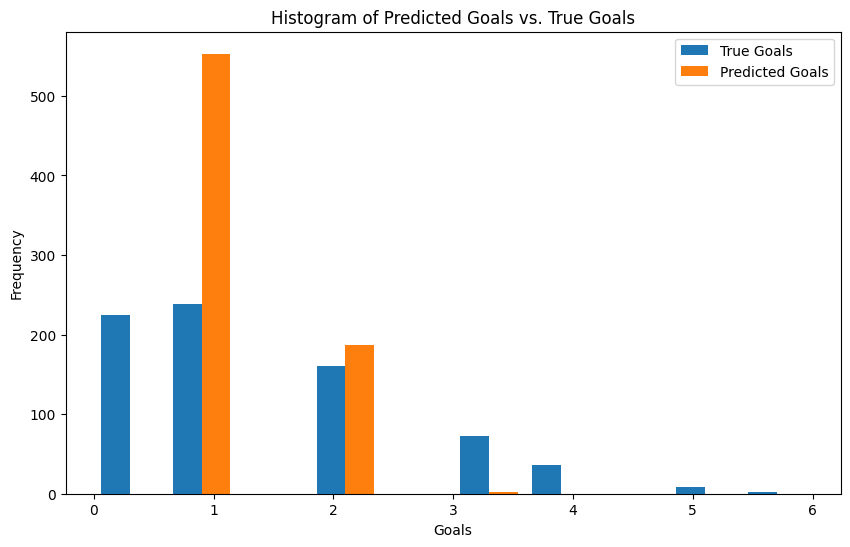

In [11]:
# Extracting actual goals for each match in the dataset
# Match[2] = home goals
# Match[3] = away goals
goals_true = []

for match in Data2:
  if len(match) >=4:
    goals_true.append([int(match[2]),int(match[3])])

# Extracting values from tensors a, b, and c
a_values = []
b_values = []
c_values = []

for value in a:
    a_values.append(float(value))

for value in b:
    b_values.append(float(value))

for value in c:
    c_values.append(float(value))


def predict_goals(home_team, away_team, a_values, b_values, c_values, teams):
    # Indices of the home and away teams
    home_team_index = getIndex(home_team, teams)
    away_team_index = getIndex(away_team, teams)
    predicted_home_goals=expectedGoals(home_team_index,away_team_index)
    predicted_away_goals=expectedGoals(away_team_index,home_team_index)
    return [predicted_home_goals, predicted_away_goals]




predicted_goals = []
actual_goals = []

# Go over each match in Data2
for match in Data2:
    if len(match) >= 4:
        home_team_index = match[0]
        away_team_index = match[1]

        # Call the predict_goals function to get the predicted goals
        predicted_match_goals = predict_goals(teams[home_team_index], teams[away_team_index], a_values, b_values, c_values, teams)

        predicted_goals.append(predicted_match_goals)
        actual_goals.append([int(match[2]), int(match[3])])


total_matches = len(actual_goals)
correct_predictions = 0


absolute_errors = []

# Iterate over each match to calculate absolute errors
for i in range(total_matches):
    absolute_error_match = [] # Each match
    #print("Actual goals: ", actual_goals[i])
    absolute_error_match.append(abs(actual_goals[i][0] - predicted_goals[i][0]))

    #print("Predicted goals: ", predicted_goals[i])
    absolute_error_match.append(abs(actual_goals[i][1] - predicted_goals[i][1]))

    absolute_errors.append(absolute_error_match)

# Calculate accuracy
correct_predictions = 0
for i in range(total_matches):
    if actual_goals[i] == predicted_goals[i]:
        correct_predictions += 1

accuracy = correct_predictions / total_matches
print("Accuracy: ", accuracy)


# Iterate over each match to calculate sum of absolute errors
sum_abs_errors = 0
for error_p_match in absolute_errors:
    sum_abs_errors += sum(error_p_match)

# Calculate mean absolute error
mean_absolute_error = sum_abs_errors / total_matches

print("Mean Absolute Error: ", mean_absolute_error)

import matplotlib.pyplot as plt

# Flatten
true_goals_flat = []
for match in actual_goals:
    for goal in match:
        true_goals_flat.append(goal)

predicted_goals_flat = []
for match in predicted_goals:
    for goal in match:
        predicted_goals_flat.append(round(goal.item()))


# Histogram of Predicted Goals vs. Actual Goals
plt.figure(figsize=(10, 6))
plt.hist([true_goals_flat, predicted_goals_flat], bins=10, label=['True Goals', 'Predicted Goals'])
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Goals vs. True Goals')
plt.legend()
plt.show()

